# <a id='top'>Clustering for uni-variate temperature </a>
Step of the codes :
- Import [modules](#modules) 
- Define [settings](#settings)  
- Define [functions](#functions)   
- [Download](#download) pc pred optim, pc_p1 and pc_obs
- [Clustering](#clustering) in PC space with k optimal
- [Identify members closest to centers](#centroids)
- [Download EOF](#download_EOF) 
- [Reconstruct](#reconstruct) centroids
- Compute [RMSE](#rmse)
- [Plot](#plot) centroids
- Identify parameters and [save data](#save)

# <a id='modules'>Import Modules</a>

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

## Clustering 
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedians import kmedians
from sklearn_extra.cluster import KMedoids

# tqdm + Remove warnings
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# <a id='settings'>Settings</a>

### Variables

In [2]:
variables = ['tas', 'pr', 'psl', 'SW', 'LW']
var_ceres = ['rsdt','rsut', 'rlut']
truncations = [18, 18, 8, 28, 22]
TITLE = 'Multi-variate'
ylabel = '$E_{tot}$'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/PPE/CNRM-CM6-1_PPE/'
path_files='/data/scratch/globc/peatier/HOME_files/PPE/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/scratch/globc/peatier/HOME_files/PPE/ENSEMBLE2/files/npy/'
path_figures = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/Clustering/figures/'

# <a id='functions'>Functions</a>

In [4]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [5]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [6]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [7]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

# <a id='download'>Download PCs</a>

In [8]:
#path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'

pc_PPE = {}
pc_obs = {}
pc_pred = {}
pc_p1 = {}
for var in variables :
    ## PPE
    path = path_files+'nc/'
    filename = 'pc_PPE_'+var+'.nc'
    pc_PPE_tmp = xr.open_mfdataset(path+filename,combine='by_coords')
    dims_dict = {'time' : 'members', 'mode' : 'modes'}
    pc_PPE[var] = pc_PPE_tmp.rename_dims(dims_dict)
    
    ## observations
    path = path_files+'nc/'
    filename = 'pc_obs_'+var+'.nc'
    pc_obs[var] = xr.open_mfdataset(path+filename,combine='by_coords')
    
    ## p1 - the first line of pc_PPE
    pc_p1[var] = pc_PPE[var]['pcs'][0,:]
    
    ## predictions
    path = path_files+'nc/'
    filename = 'pc_pred_'+var+'.nc'
    pc_pred_tmp = xr.open_mfdataset(path+filename,combine='by_coords')
    pc_pred[var] = pc_pred_tmp.rename({'__xarray_dataarray_variable__' : 'pcs'})

In [9]:
#path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path = path_files+'nc/'
pc_optim = {}
for var in variables :
    filename = 'optim_pc_PPE_'+var+'_multi.nc'
    pc_optim[var] = xr.open_mfdataset(path+filename,combine='by_coords')

In [10]:
df_optim = pd.DataFrame()
cpt_trunc = 0
for var in variables :
    trunc = truncations[cpt_trunc]
    for i in range(1,trunc+1,1) :
        df_optim['EOF '+str(i)+' '+var] = pc_optim[var]['EOF '+str(i)].values
    cpt_trunc += 1
df_optim['LHS index'] = pc_optim[var]['LHS index'].values

In [11]:
df_optim

EOF 1 tas  EOF 2 tas  EOF 3 tas  EOF 4 tas  EOF 5 tas  EOF 6 tas  \
0      0.053160   0.591416   0.177104   0.866376  -0.718467  -0.659540   
1     -1.011793   1.339372   1.565485  -0.114614  -2.109373   0.004198   
2     -0.384961   0.556234  -0.396392  -0.059524  -1.318948   0.235323   
3     -0.270988   0.208586   0.606975   1.005541  -0.550034   0.227348   
4     -0.299352   0.309064   2.783405  -0.125267  -0.715340   0.787181   
...         ...        ...        ...        ...        ...        ...   
4984   0.466418   0.773169  -0.844275  -0.764109  -0.894000  -0.046908   
4985  -0.627136   0.590900   1.234955  -0.434820   0.205836   0.752006   
4986   0.203675   0.899939   0.128886   0.561057   0.135676  -0.040235   
4987  -0.938848   0.741590   1.616601  -0.705452   0.071571   0.880203   
4988  -0.098217   0.735165   0.579784  -0.356114   0.113721   0.339570   

      EOF 7 tas  EOF 8 tas  EOF 9 tas  EOF 10 tas  ...  EOF 14 LW  EOF 15 LW  \
0     -0.043037   0.556143   0.368302   -1.033655  ...  -0.098080  -0.975946   
1      0.100010  -0.431711   0.024609    0.297679  ...  -0.379823   1.387612   
2      0.289680  -0.226521  -0.024458   -0.126000  ...   0.251287   0.507676   
3     -0.026970  -0.256704   0.440614   -0.158742  ...  -0.630755  -0.060103   
4      0.565415  -1.050571   0.028596    0.408537  ...   0.216559   1.040399   
...         ...        ...        ...         ...  ...        ...        ...   
4984  -0.715592  -0.161486   0.356400    0.834269  ...   0.022396   1.208086   
4985  -0.547507   1.033733  -0.695691    0.887514  ...  -0.482902  -0.237134   
4986   0.744816   1.110649  -0.499779   -0.410537  ...   0.622922   0.191361   
4987  -0.589251   1.118385  -0.486073    1.071030  ...   0.564887  -0.021714   
4988   0.282826   0.587459   0.728209   -0.162594  ...  -1.069734   0.796368   

      EOF 16 LW  EOF 17 LW  EOF 18 LW  EOF 19 LW  EOF 20 LW  EOF 21 LW  \
0     -0.281429  -0.185335   0.176638  -0.306223   0.099916   0.654717   
1     -0.496919   1.171483  -0.344917  -1.007774  -0.146686   1.032652   
2     -0.793967  -1.047735  -0.120428   0.425087  -0.646289   0.349680   
3      0.575651  -0.300881   0.266193   1.178987   0.072353   0.537443   
4     -0.862432   0.791998  -0.452841   0.318223  -0.636524  -0.220940   
...         ...        ...        ...        ...        ...        ...   
4984   0.564893  -0.204087  -0.464265  -1.084542  -0.313619   0.227772   
4985  -0.166283   0.349432   0.410475  -0.424606  -0.472399  -0.800697   
4986  -1.198509   1.687077  -0.203311  -1.362365  -0.125646  -0.036607   
4987  -1.196097   0.777178   0.084771  -0.312025  -0.859730  -0.545371   
4988   1.706317   0.762519   0.715876   0.538907  -0.230283  -0.035101   

      EOF 22 LW  LHS index  
0     -1.133540          0  
1      0.005230         14  
2      0.252881         24  
3     -0.899818         36  
4      0.151882         41  
...         ...        ...  
4984   1.008630      99929  
4985   0.719077      99933  
4986   0.229306      99962  
4987   0.771119      99976  
4988  -1.035494      99988  

[4989 rows x 95 columns]

# <a id='clustering'>Clustering analysis</a>

In [12]:
## Create the initial matrix to cluster 
list_index = []
cpt_trunc = 0
trunc_cluster = 5
for var in variables :
    trunc = truncations[cpt_trunc]
    for i in range(1,trunc_cluster+1,1) :
        tmp = 'EOF '+str(i)+' '+var
        list_index.append(tmp)
    cpt_trunc += 1
    
tmp = df_optim[list_index].transpose().reset_index().drop(['index'], axis=1)
tmp_r = tmp.transpose()

In [13]:
n_clusters=12
kmedoids = KMedoids(n_clusters).fit(tmp_r)
#kmean = KMeans(n_clusters).fit(tmp_r)

cluster = kmedoids.labels_
centers = kmedoids.cluster_centers_
dist_from_center = kmedoids.transform(tmp_r)

### Here, the candidates are the centroïds 

In [14]:
pc_pseudo_centroids = centers.copy()

# <a id='save'>Identify parameters and save</a>

In [15]:
ind_centroids = kmedoids.medoid_indices_
ind_centroids

array([1400, 4820, 2626, 2774, 4369, 4023, 4141, 2023, 2261, 3916, 3288,
       2041])

In [16]:
## Appliquer les indices à df_optim pour trouver les indices LHS
ind_LHS = []
pc_cand = []
for i in tqdm(ind_centroids) :
    x = df_optim.iloc[i]
    pc_cand.append(x.drop('LHS index').values)
    ind_LHS.append(int(x['LHS index']))

100%|██████████| 12/12 [00:00<00:00, 2030.24it/s]


In [17]:
## Récupérer la df LHS des paramètres pour l'émulation
path = "/data/scratch/globc/peatier/HOME_files/PPE/ENSEMBLE2/files/npy"
LHS = np.load(file=path+"/LHS100000_param.npy")
pd_LHS = pd.DataFrame(LHS)
pd_LHS

0         1         2          3         4         5         6   \
0      0.237758  1.166405  0.880392  28.558061 -0.013007  5.622351  4.162592   
1      0.126381  0.534863  1.789610  28.480600 -0.198482  4.866094  7.643592   
2      0.161582  2.774511  1.700513  18.863644 -0.035909  1.940661  1.154684   
3      0.269570  0.617033  1.287904  21.638356 -0.425201  1.031540  7.213933   
4      0.152002  2.445601  1.837120  17.701181 -0.021411  9.066585  2.859292   
...         ...       ...       ...        ...       ...       ...       ...   
99995  0.153543  0.610786  2.065459  14.516229 -0.463268  8.471504  1.785016   
99996  0.097080  2.208875  1.340062  10.473539 -0.304292  3.296326  1.022391   
99997  0.259355  1.213350  1.786574  19.759766 -0.205054  1.078345  7.513847   
99998  0.136834  1.283644  0.691964   9.627438 -0.064111  1.770910  6.090318   
99999  0.273117  1.155501  1.385027   4.996543 -0.181567  4.706733  0.164435   

             7         8         9   ...        20         21        22  \
0      0.003295  0.000736  0.003610  ... -4.889411 -46.181951  0.087037   
1      0.002512  0.000263  0.002387  ... -3.468324 -48.234995  0.013971   
2      0.002071  0.000726  0.007475  ... -3.657207 -38.497415  0.067244   
3      0.006568  0.000110  0.006095  ... -1.836464 -41.742492  0.088597   
4      0.001732  0.000786  0.004183  ... -4.735136 -39.076371  0.024863   
...         ...       ...       ...  ...       ...        ...       ...   
99995  0.003410  0.000638  0.001517  ... -2.477336 -33.657363  0.069372   
99996  0.002612  0.000963  0.003046  ... -3.246914 -25.832085  0.054131   
99997  0.001859  0.000531  0.009371  ... -4.245520 -40.163139  0.060605   
99998  0.009920  0.000873  0.007538  ... -2.958271 -48.699157  0.029157   
99999  0.000597  0.000222  0.002823  ... -2.404555 -49.041751  0.027010   

              23        24        25        26        27        28        29  
0       5.612146  0.000024  0.753132  0.692837  0.800605  0.649651  2.439231  
1      18.155762  0.000076  0.655943  0.845886  0.712394  0.628513  9.773983  
2       0.206254  0.000061  0.794010  0.880129  0.996989  0.713900  0.379772  
3      16.561323  0.000062  0.920107  0.717110  0.717044  0.901268  9.714537  
4       5.099756  0.000026  0.555454  0.882347  0.915713  0.653554  2.734065  
...          ...       ...       ...       ...       ...       ...       ...  
99995   5.107703  0.000088  0.887371  0.829693  0.874071  0.772201  2.832374  
99996  17.028286  0.000049  0.527949  0.952927  0.519428  0.923016  2.204335  
99997   9.389115  0.000087  0.854778  0.778580  0.562029  0.586887  1.455238  
99998  19.291965  0.000057  0.823763  0.609284  0.856318  0.536784  1.115876  
99999  16.261407  0.000063  0.510950  0.702040  0.506628  0.862903  9.175721  

[100000 rows x 30 columns]

In [26]:
## chercher les candidats dans la df avec les indices de LHS 
param_cand = []
for ind in ind_LHS : 
    tmp = pd_LHS.iloc[ind]
    param_cand.append(tmp)

In [27]:
## -- Save parameters in .txt file 
xr_param_cand = array(param_cand)
path = path_files+'txt/'
filename = 'Candidates_multi_x_kmedian_Avril2024.txt'
np.savetxt(path+filename, xr_param_cand)

In [19]:
## -- Save centroids PCs in .nc file 
xr_pc_pseudo_centroids = xr.DataArray(pc_cand)
path = path_files+'nc/'
filename = 'PC_candidates_multi_kmedian.nc'
xr_pc_pseudo_centroids.to_netcdf(path+filename)

# <a id='download_EOF'>Download EOF solvers</a>

In [17]:
import pickle
path = path_files+'pkl/'
solver = {}

for var in variables :
    # open a file, where you stored the pickled data
    file = open(path+'solver_'+var+'.pkl', 'rb')

    # dump information to that file
    solver[var] = pickle.load(file)

    # close the file
    file.close()

In [18]:
eofs = {}
variances = {}
for var in variables :
    eofs[var] = solver[var].eofsAsCovariance(pcscaling=1)
    variances[var] = solver[var].varianceFraction() 

In [19]:
# Reference simulation tas
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = 'tas_*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, ['tas'])

In [20]:
lat = p1_amip['lat']
lon = p1_amip['lon']
eofs_nb = arange(1,104,1)
eofs_xr = {}
eofs_combined = {}
for var in variables :
    eofs_xr = xr.DataArray(eofs[var], 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])#.to_dataset(name=var)
    ## --Combine the modes for reconstruction
    eofs_combined[var] = eofs_xr

# <a id='reconstruct'>Reconstruct spatial fields</a>

In [32]:
## Centroïds
list_index = []
cpt_trunc = 0
for var in variables :
    trunc = truncations[cpt_trunc]
    for i in range(1,trunc+1,1) :
        tmp = 'EOF '+str(i)+' '+var
        list_index.append(tmp)
    cpt_trunc += 1
        
df_pc_pseudo_centroids = pd.DataFrame(pc_cand, columns = list_index)
df_pc_pseudo_centroids

EOF 1 tas  EOF 2 tas  EOF 3 tas  EOF 4 tas  EOF 5 tas  EOF 6 tas  \
0   -0.275618   0.629781   0.085605  -0.804840  -0.543540  -0.261698   
1   -0.082960   0.900003   0.008403  -0.119474  -0.961918   0.209701   
2    0.204451   0.405106   0.806507  -0.653811  -0.552561  -0.086349   
3   -0.441859   0.724435   0.411334   0.353839  -0.658697   0.704817   
4   -0.436733   1.029568   0.350187  -0.672196  -1.054713   0.489864   
5   -0.182051   0.885834   0.256452  -0.391710  -1.078149   0.388733   
6   -0.087323   1.125595   0.511476  -0.237499  -0.395194   0.174789   
7   -0.475753   0.800148   0.158513  -0.684564  -1.003410   0.412602   
8   -0.081378   0.437503   0.529736   0.121945  -1.344852   0.089181   
9   -0.281691   0.644261   1.740361   0.028048  -0.740704   0.454259   
10  -0.401978   0.746678  -0.102676   0.139227  -0.851382   0.029180   
11  -0.680801   1.085814  -0.130705  -0.069398  -0.612607  -0.626539   

    EOF 7 tas  EOF 8 tas  EOF 9 tas  EOF 10 tas  ...  EOF 13 LW  EOF 14 LW  \
0   -0.254450  -0.405209   0.677749    0.747427  ...  -1.098495  -0.625251   
1   -0.137804   0.195247   0.329132    0.026794  ...   0.379935  -1.078837   
2    0.763537   1.630290  -0.475706   -0.182049  ...  -0.034319  -0.635084   
3    0.329780   0.220750  -0.954062    0.865665  ...  -0.091767   0.718588   
4   -0.464771  -0.261866  -0.482381   -0.364943  ...   0.619481  -0.082582   
5   -0.602707  -0.576048   0.421399   -1.305022  ...  -0.283399   0.122709   
6   -0.581872  -0.087364   0.022137    0.429858  ...  -0.633904  -0.948154   
7   -0.221400   0.660306   0.859110    0.339852  ...   0.290102   0.033063   
8   -0.676219  -0.614944   0.400977   -0.144236  ...  -1.156890   0.199036   
9   -0.230606   0.566910  -0.223838    0.441180  ...   0.091224  -0.901650   
10   0.369774   0.851823  -1.160415   -0.216339  ...  -0.223294  -0.145807   
11  -0.036881  -0.003360  -0.623763    0.377284  ...  -0.639651  -0.021073   

    EOF 15 LW  EOF 16 LW  EOF 17 LW  EOF 18 LW  EOF 19 LW  EOF 20 LW  \
0    0.187792   1.199620   0.676512  -0.152496  -0.326701  -0.038242   
1    0.545647   1.281493  -0.342353  -0.290440   0.758918  -0.668235   
2   -0.139900   0.705753   0.600064   0.693466  -0.678987  -0.942827   
3   -0.868611  -0.636934  -0.007246  -0.230476  -1.272267  -0.324418   
4    0.745285   0.764674  -0.457703   0.135234   0.770631  -0.469846   
5   -0.939757   0.480794  -0.122416  -0.880011   1.083770   0.544329   
6    0.122633   1.298336   0.630598   0.274972   0.717510   0.746906   
7    0.148507   0.077549   1.598519   0.196924  -0.939822   0.256578   
8   -0.750866  -0.263315  -0.812557   0.340683  -0.163949   0.224698   
9    0.606690  -0.414344   1.807598   0.147222   0.141485  -0.667852   
10  -1.948644   0.853959   0.818526  -0.106906  -0.792803   0.598875   
11   0.064870   1.638404   0.103346  -0.415283  -0.062938  -0.377343   

    EOF 21 LW  EOF 22 LW  
0   -1.298347  -0.803987  
1    0.604286  -0.786314  
2   -0.877236   0.252579  
3   -0.240834   0.073872  
4    1.070308  -0.330201  
5   -0.025371   0.034883  
6    0.140934  -0.540720  
7    0.245326   0.585783  
8    0.140893   0.151059  
9    0.181633  -0.501271  
10  -1.083273   0.386720  
11   0.136306  -0.229474  

[12 rows x 94 columns]

In [33]:
## Centroïds

X_rec_pseudo_centroids = {}
cpt_trunc = 0
for var in variables :
    list_index = []
    X_rec_pseudo_centroids[var] = []
    trunc = truncations[cpt_trunc]
    for i in range(1,trunc+1,1) :
        tmp = 'EOF '+str(i)+' '+var
        list_index.append(tmp)
    pc_pseudo_centroids_list = df_pc_pseudo_centroids[list_index]
    for i in range(0,n_clusters,1) :
        pc = pc_pseudo_centroids_list.iloc[i]
        X_rec_tmp = np.dot(eofs_combined[var][0:trunc,:,:].transpose(),pc[0:trunc])
        X_rec_pseudo_centroids[var].append(X_rec_tmp)
    cpt_trunc +=1

In [34]:
## Observations
X_rec_obs = {}
cpt_trunc = 0
for var in variables :
    trunc = truncations[cpt_trunc]
    X_rec_obs[var] = np.dot(eofs_combined[var][0:trunc,:,:].transpose(),pc_obs[var]['pseudo_pcs'][0:trunc].values)
    cpt_trunc += 1

In [35]:
xr_obs = {}
for var in variables :
    xr_obs[var] = xr.DataArray(X_rec_obs[var]).to_dataset(name=var)
    xr_obs[var] = xr_obs[var].rename_dims(dims_dict={'dim_0' : 'lon', 'dim_1' : 'lat'})
    xr_obs[var] = xr_obs[var].assign_coords({"lat": eofs_xr['lat'], 'lon' : eofs_xr['lon']})
    xr_obs[var] = xr_obs[var][var].transpose()
#xr_obs

# Compute MSE

In [36]:
path_file = path_files+'npy/'
Mean = {}
for var in variables :
    filename = 'CNRMppe_decomposition_mean_'+str(var)+'.npy'
    Mean[var] =  pd.read_pickle(path_file+filename).to_xarray().to_array()
    Mean[var] = Mean[var][0,:,:].rename({'variable':'mode'})

W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(var)+'.npy')
W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(var)+'.npy')
W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(var)+'.npy')

In [37]:
MSE_centroids = {}
xr_fig = {}
for var in variables :
    MSE_centroids[var] = []
    for i in range(0,n_clusters,1) :
        xr_fig[var] = xr.DataArray(X_rec_pseudo_centroids[var][i]).to_dataset(name=var)
        xr_fig[var] = xr_fig[var].rename_dims(dims_dict={'dim_0' : 'lon', 'dim_1' : 'lat'})
        xr_fig[var] = xr_fig[var].assign_coords({"lat": eofs_xr['lat'], 'lon' : eofs_xr['lon']})
        xr_fig[var] = xr_fig[var][var].transpose()
    
        tmp = MSE_rec(xr_fig[var], xr_obs[var], Mean[var], W_rmse_2D)
        MSE_centroids[var].append(float(tmp))

In [38]:
MSE_rec_p1 = {}
cpt_trunc = 0
for var in variables :
    trunc = truncations[cpt_trunc]
    rec_anom_mod_w = reconstruct_X(eofs_combined[var][0:trunc,:,:], pc_p1[var][0:trunc], nb_dims=2)
    MSE_rec_p1[var] = MSE_rec(rec_anom_mod_w, xr_obs[var], Mean[var], W_rmse_2D)
    cpt_trunc += 1

In [39]:
pd_MSE_centroids = pd.DataFrame(MSE_centroids)
pd_MSE_centroids

tas        pr           psl          SW         LW
0   0.877651  0.851350   4469.961860   95.642173  29.273837
1   0.916088  1.157973   2797.428729   89.870749  33.395113
2   0.926198  1.298090  15111.669588  100.057947  32.587008
3   0.686243  1.319848   5612.148190   92.786079  42.904970
4   0.826371  1.195998   4460.259725   67.858386  33.976704
5   0.954174  1.105184   6508.847231  126.578382  48.641656
6   1.005929  1.036988   7952.420052  116.834833  36.415302
7   0.712296  1.257354   3641.280643   75.944551  41.419808
8   0.790957  1.463311   5266.435435   69.500058  43.531509
9   0.610077  1.303469   5935.333154   94.609488  43.932406
10  0.812871  1.802966   9510.539021   79.748824  42.967760
11  0.962733  1.097701   5312.250128   75.691339  29.863281

In [40]:
for var in variables :
    tmp = pd_MSE_centroids[var]/float(MSE_rec_p1[var])
    pd_MSE_centroids[var+'_norm'] = tmp

In [41]:
pd_MSE_centroids

tas        pr           psl          SW         LW  tas_norm  \
0   0.877651  0.851350   4469.961860   95.642173  29.273837  0.833768   
1   0.916088  1.157973   2797.428729   89.870749  33.395113  0.870284   
2   0.926198  1.298090  15111.669588  100.057947  32.587008  0.879888   
3   0.686243  1.319848   5612.148190   92.786079  42.904970  0.651930   
4   0.826371  1.195998   4460.259725   67.858386  33.976704  0.785052   
5   0.954174  1.105184   6508.847231  126.578382  48.641656  0.906465   
6   1.005929  1.036988   7952.420052  116.834833  36.415302  0.955632   
7   0.712296  1.257354   3641.280643   75.944551  41.419808  0.676681   
8   0.790957  1.463311   5266.435435   69.500058  43.531509  0.751409   
9   0.610077  1.303469   5935.333154   94.609488  43.932406  0.579573   
10  0.812871  1.802966   9510.539021   79.748824  42.967760  0.772227   
11  0.962733  1.097701   5312.250128   75.691339  29.863281  0.914596   

     pr_norm  psl_norm   SW_norm   LW_norm  
0   0.085622  0.535459  0.865870  0.725098  
1   0.116460  0.335105  0.813620  0.827179  
2   0.130552  1.810233  0.905847  0.807163  
3   0.132740  0.672282  0.840013  1.062734  
4   0.120284  0.534296  0.614337  0.841585  
5   0.111151  0.779698  1.145943  1.204828  
6   0.104292  0.952624  1.057732  0.901988  
7   0.126455  0.436191  0.687543  1.025947  
8   0.147169  0.630869  0.629200  1.078253  
9   0.131093  0.710996  0.856521  1.088183  
10  0.181329  1.139272  0.721984  1.064289  
11  0.110398  0.636357  0.685251  0.739698

In [42]:
Etot = []
for i in range(0,n_clusters,1) :
    tmp = pd_MSE_centroids.iloc[i]
    tmp_sum = tmp['tas_norm']+tmp['pr_norm']+tmp['psl_norm']+tmp['SW_norm']+tmp['LW_norm']
    tmp_mean = tmp_sum/5
    Etot.append(tmp_mean)

In [43]:
pd_MSE_centroids['MSE multi'] = Etot
pd_MSE_centroids

tas        pr           psl          SW         LW  tas_norm  \
0   0.877651  0.851350   4469.961860   95.642173  29.273837  0.833768   
1   0.916088  1.157973   2797.428729   89.870749  33.395113  0.870284   
2   0.926198  1.298090  15111.669588  100.057947  32.587008  0.879888   
3   0.686243  1.319848   5612.148190   92.786079  42.904970  0.651930   
4   0.826371  1.195998   4460.259725   67.858386  33.976704  0.785052   
5   0.954174  1.105184   6508.847231  126.578382  48.641656  0.906465   
6   1.005929  1.036988   7952.420052  116.834833  36.415302  0.955632   
7   0.712296  1.257354   3641.280643   75.944551  41.419808  0.676681   
8   0.790957  1.463311   5266.435435   69.500058  43.531509  0.751409   
9   0.610077  1.303469   5935.333154   94.609488  43.932406  0.579573   
10  0.812871  1.802966   9510.539021   79.748824  42.967760  0.772227   
11  0.962733  1.097701   5312.250128   75.691339  29.863281  0.914596   

     pr_norm  psl_norm   SW_norm   LW_norm  MSE multi  
0   0.085622  0.535459  0.865870  0.725098   0.609163  
1   0.116460  0.335105  0.813620  0.827179   0.592530  
2   0.130552  1.810233  0.905847  0.807163   0.906737  
3   0.132740  0.672282  0.840013  1.062734   0.671940  
4   0.120284  0.534296  0.614337  0.841585   0.579111  
5   0.111151  0.779698  1.145943  1.204828   0.829617  
6   0.104292  0.952624  1.057732  0.901988   0.794454  
7   0.126455  0.436191  0.687543  1.025947   0.590563  
8   0.147169  0.630869  0.629200  1.078253   0.647380  
9   0.131093  0.710996  0.856521  1.088183   0.673273  
10  0.181329  1.139272  0.721984  1.064289   0.775820  
11  0.110398  0.636357  0.685251  0.739698   0.617260

# <a id='plot'>Plot</a>

In [44]:
def plot_map(dataset, var,  palette, xmin, xmax, label, title, name_fig) :
    
    lats = dataset['lat'][:]
    lons = dataset['lon'][:]

    var, lons = add_cyclic_point(var, coord=lons)


    fig = plt.figure(figsize=(10, 5))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.Robinson())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = abs(xmin)+abs(xmax)+3
    cmap = plt.get_cmap(palette)  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=xmin,\
                   vmax=xmax, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='vertical', drawedges=False, extend='both')

    cbar.set_label(label, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)


    ax.coastlines()

    # Save figure ---------------
    plt.savefig(path_figures+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
    #----------------------------

    plt.show()

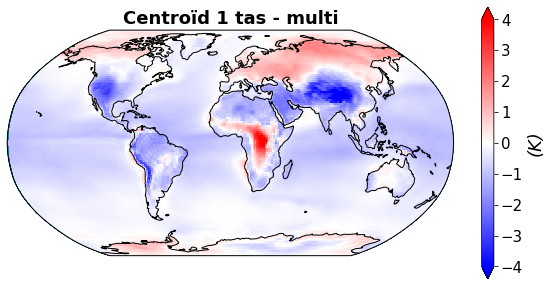

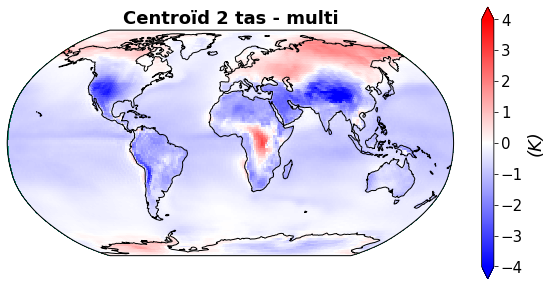

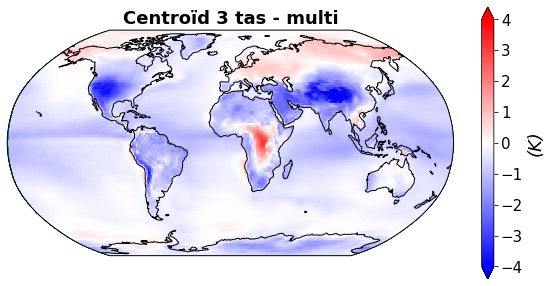

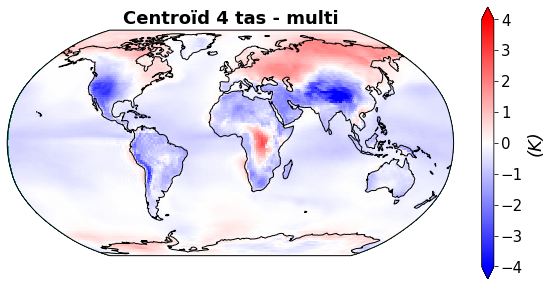

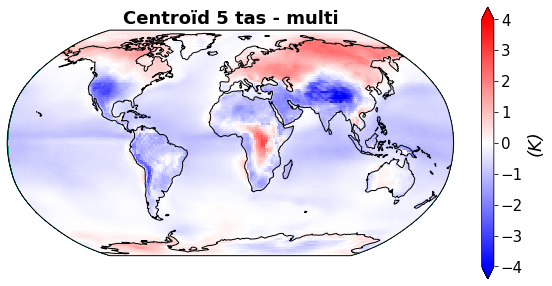

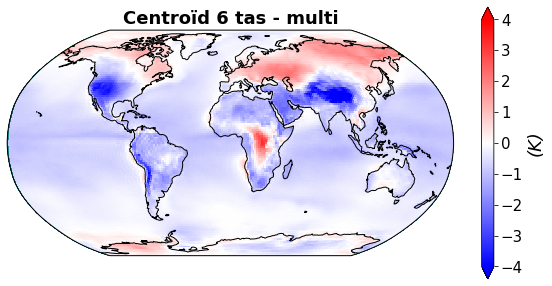

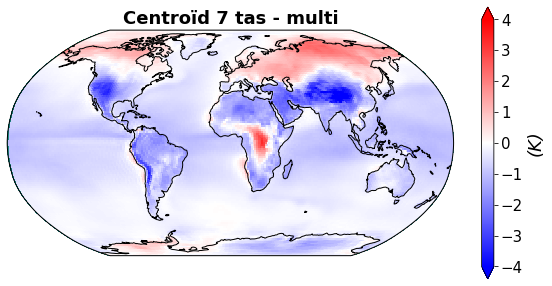

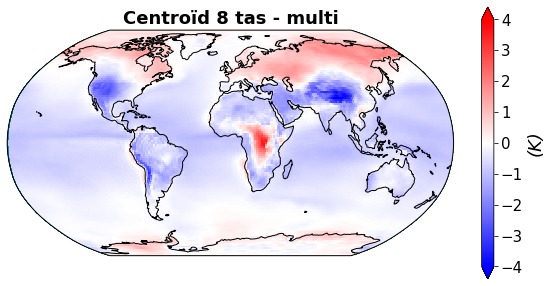

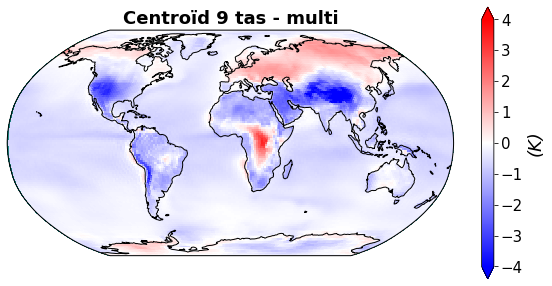

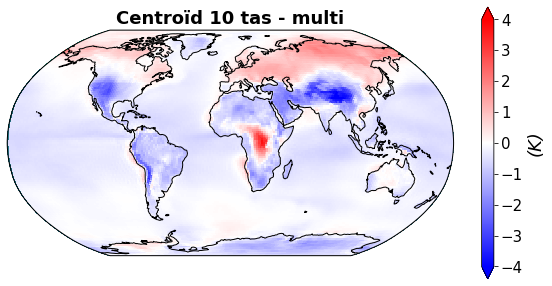

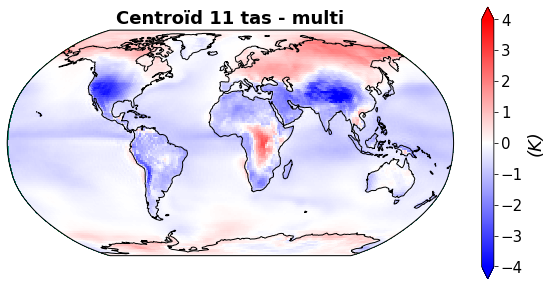

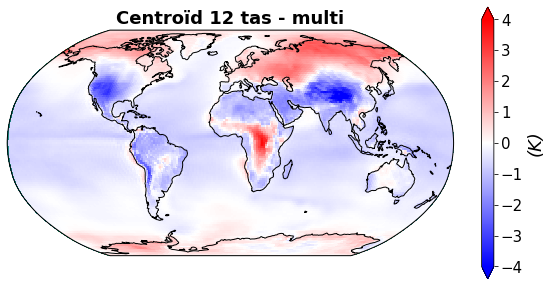

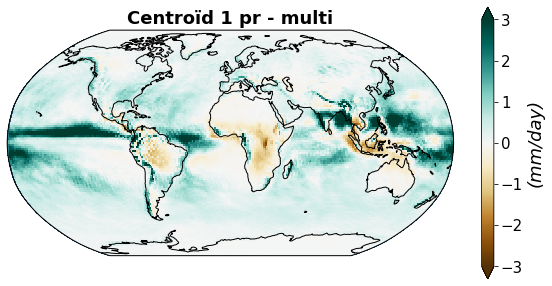

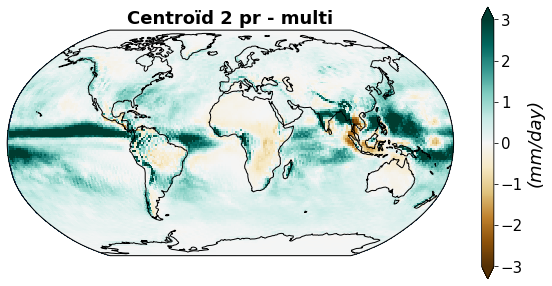

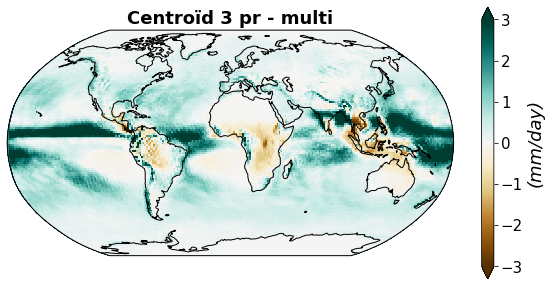

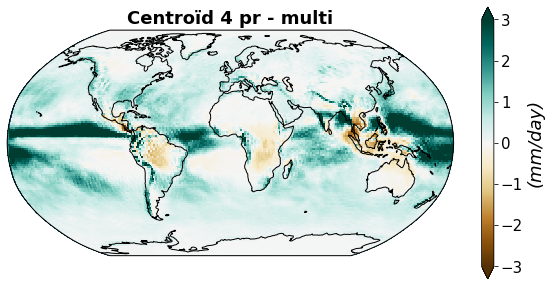

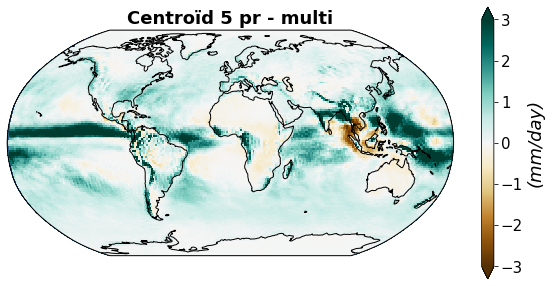

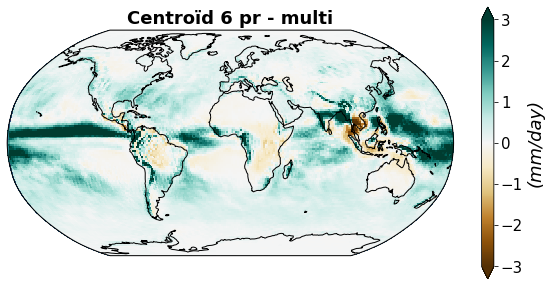

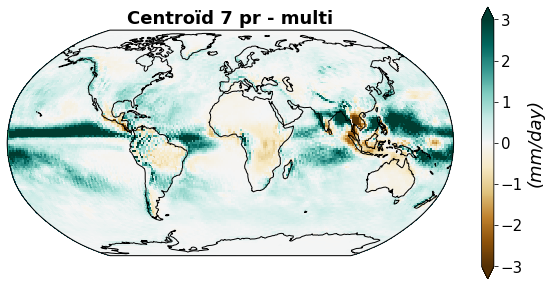

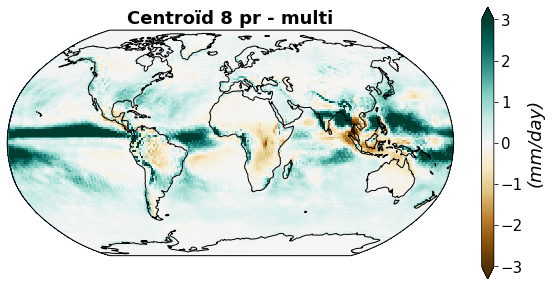

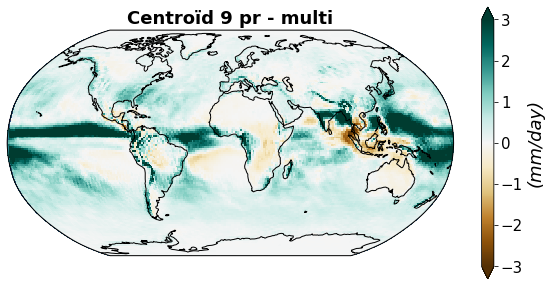

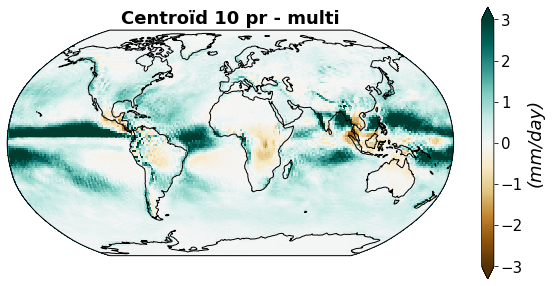

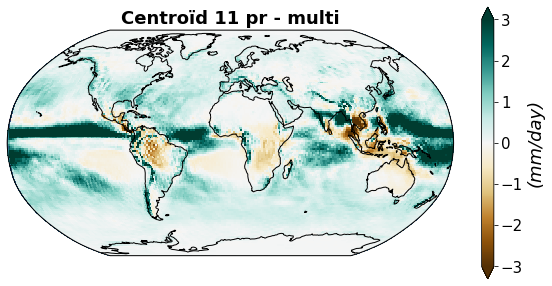

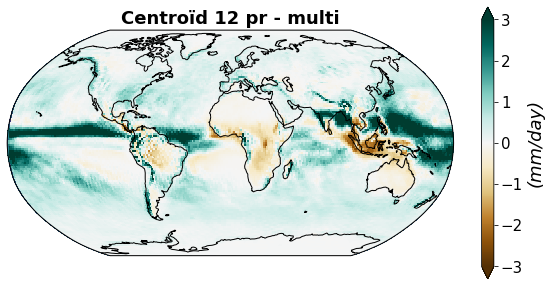

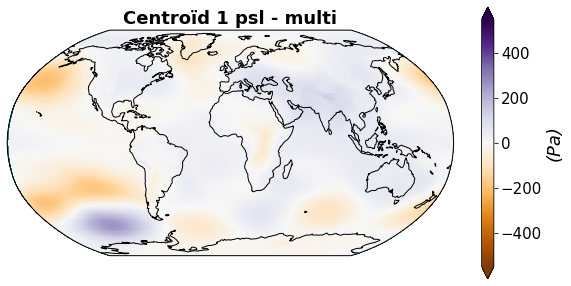

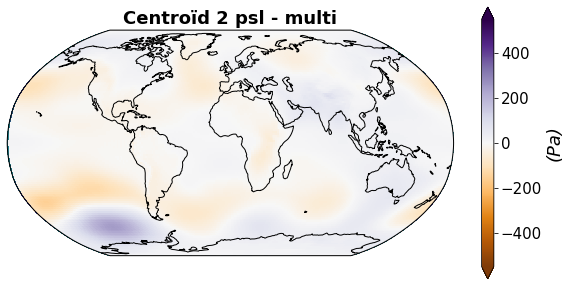

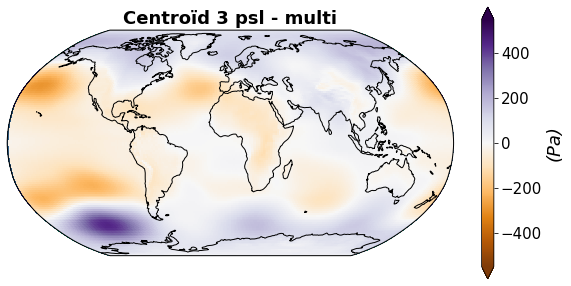

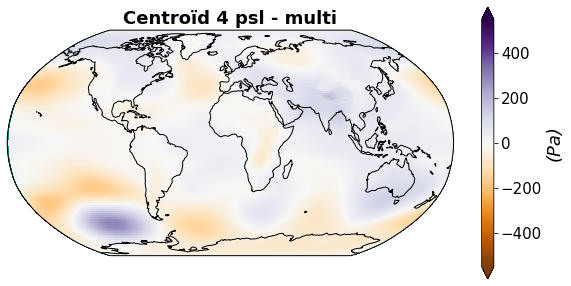

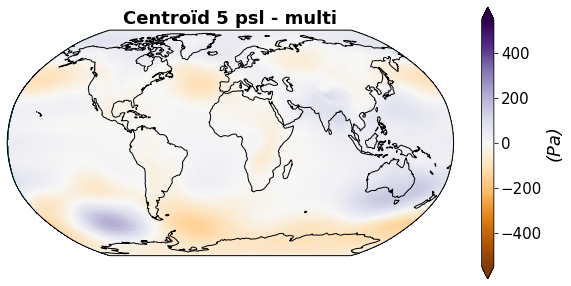

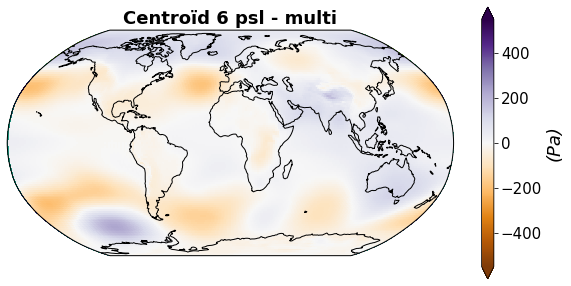

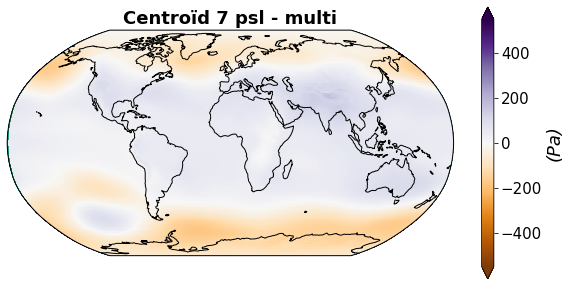

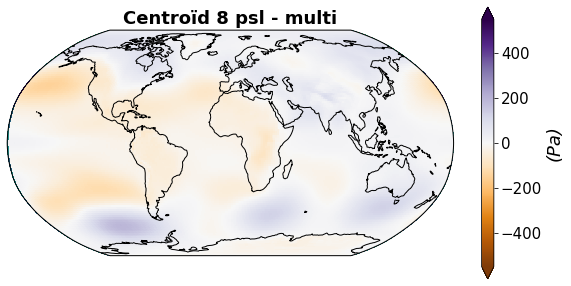

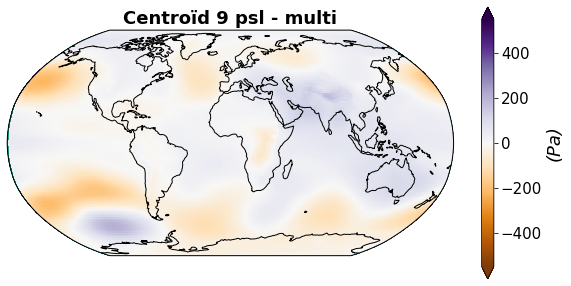

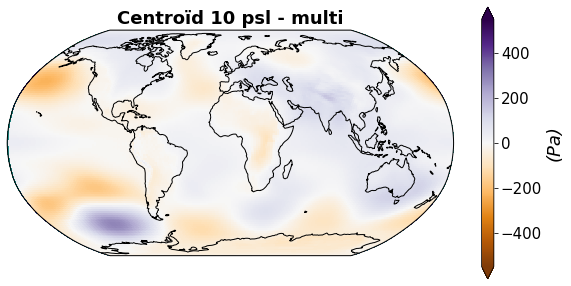

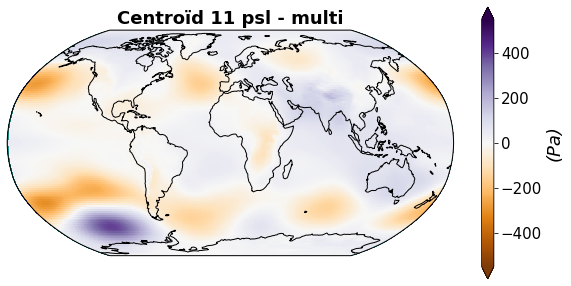

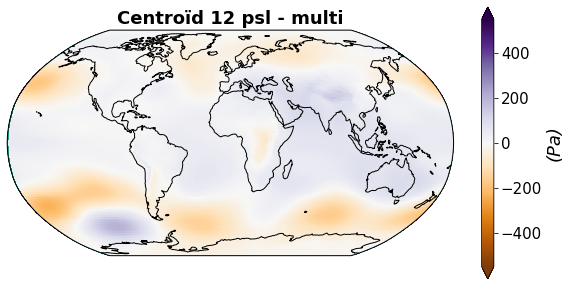

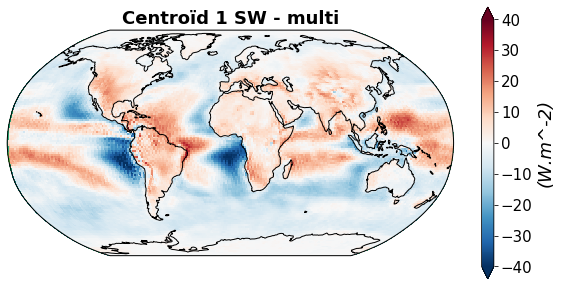

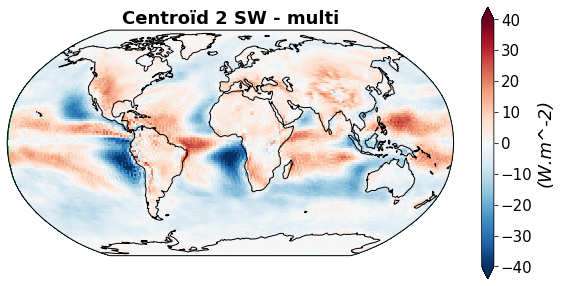

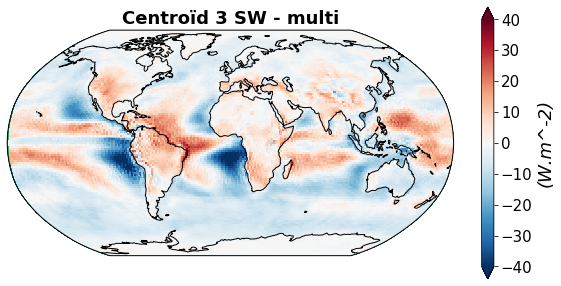

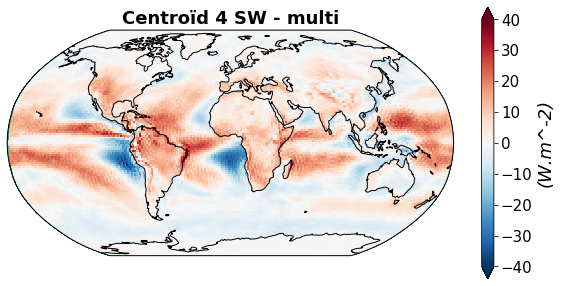

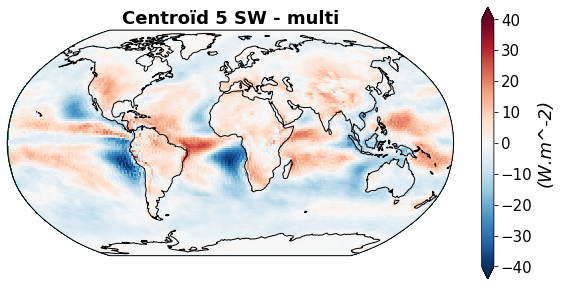

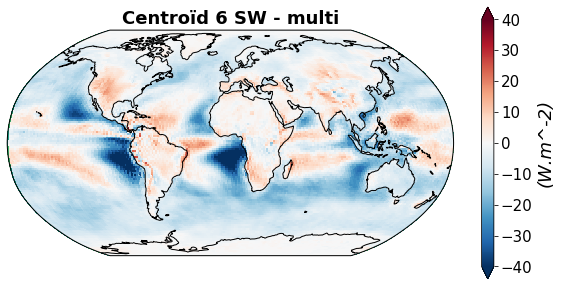

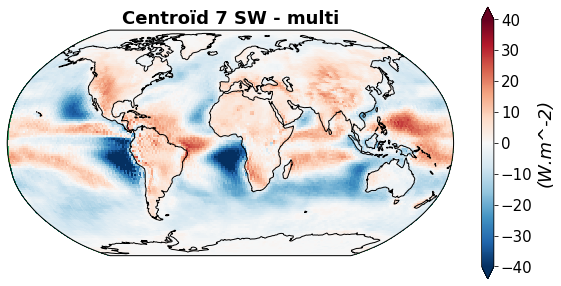

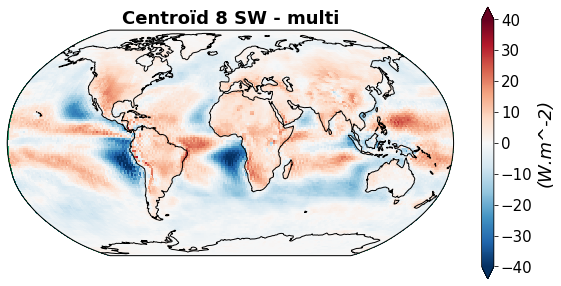

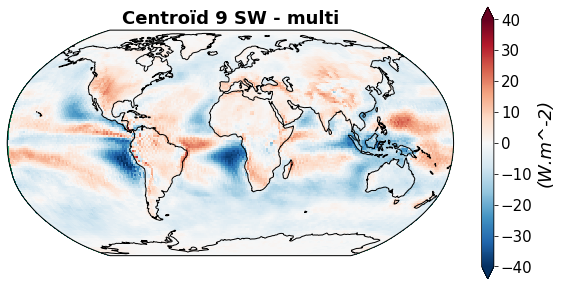

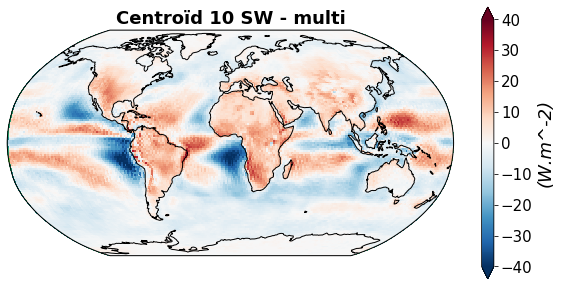

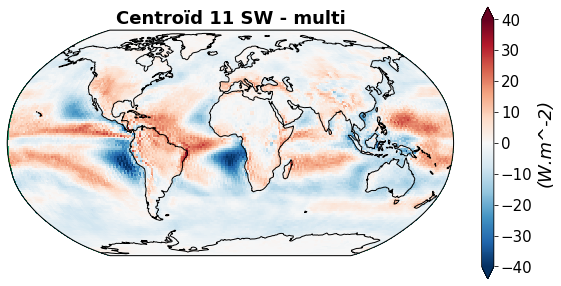

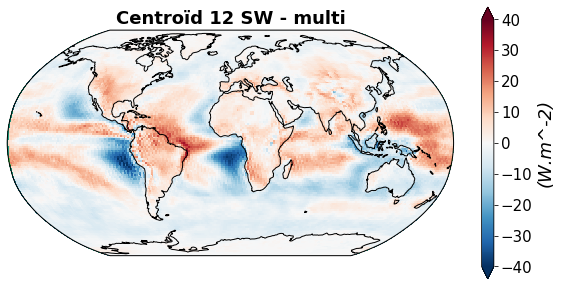

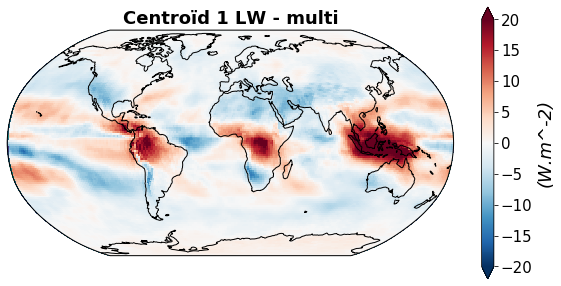

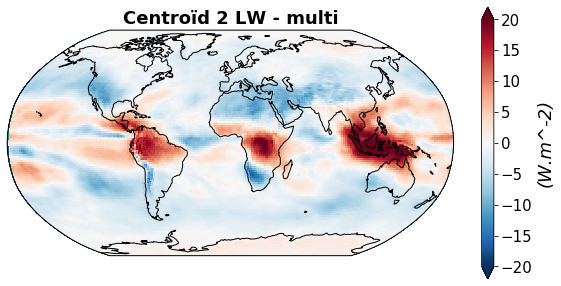

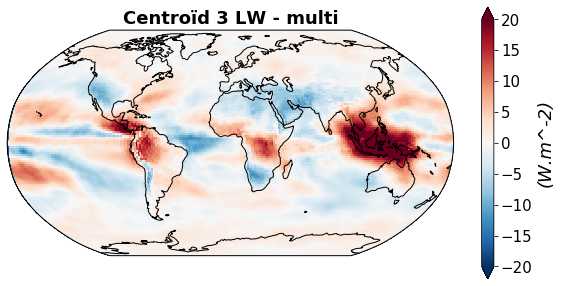

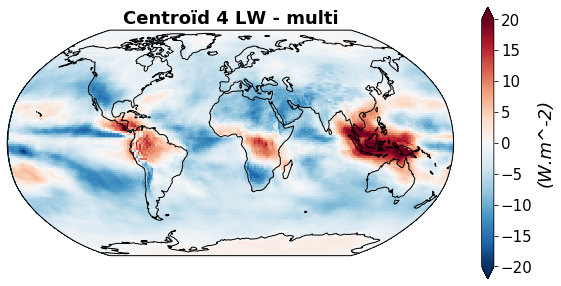

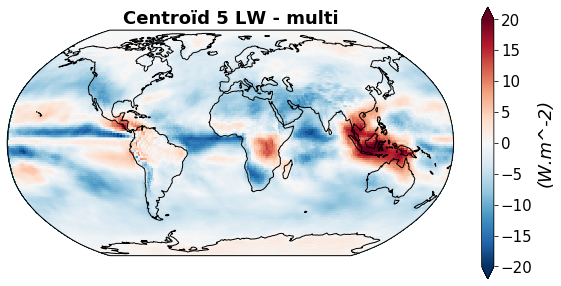

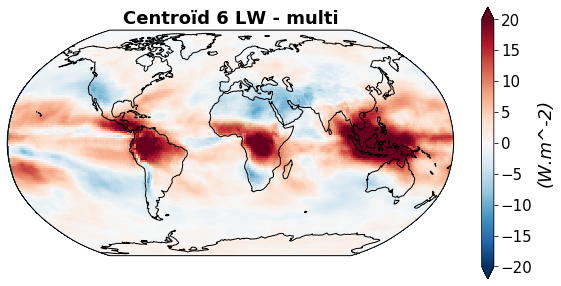

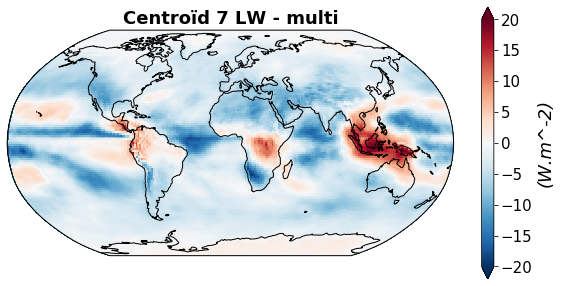

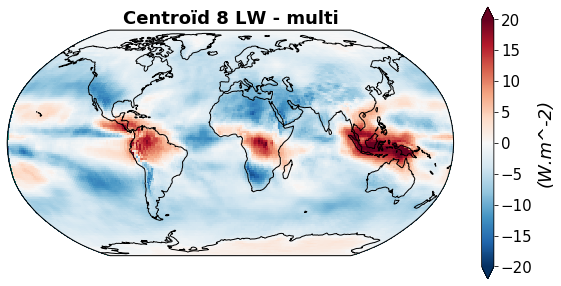

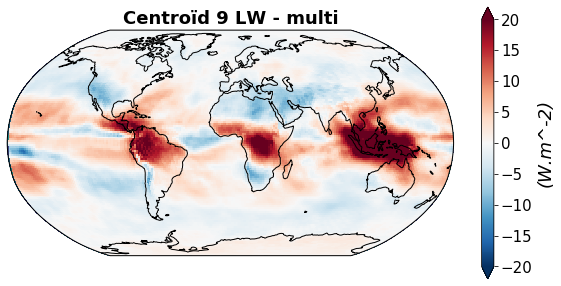

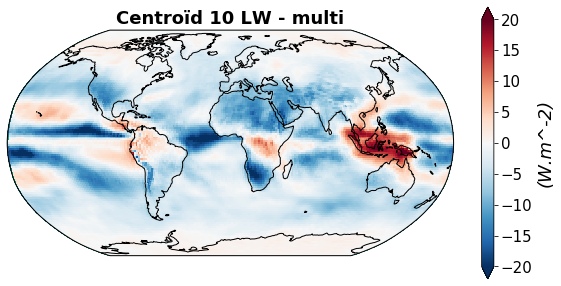

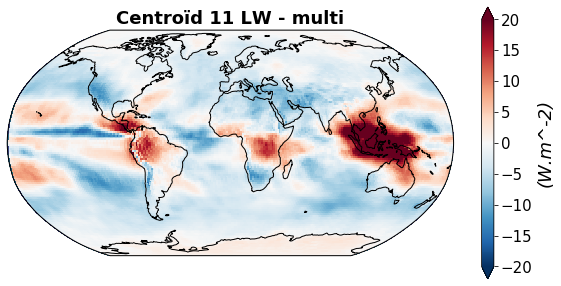

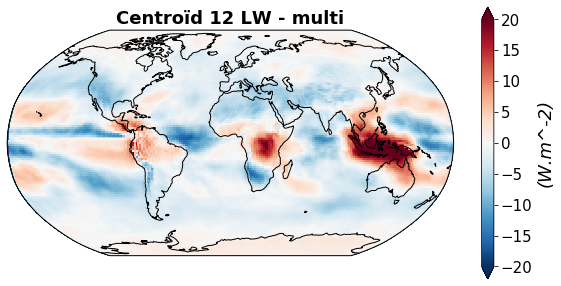

In [45]:
x = [4,3,550,40,20]
units = ['K', 'mm/day', 'Pa', 'W.m^-2', 'W.m^-2']
cpt=0
pal = ['bwr','BrBG', 'PuOr', 'RdBu_r', 'RdBu_r']
cpt=0
for var in variables :
    for i in range(0,n_clusters,1) :
        xr_fig = xr.DataArray(X_rec_pseudo_centroids[var][i]).to_dataset(name=var)
        xr_fig = xr_fig.rename_dims(dims_dict={'dim_0' : 'lon', 'dim_1' : 'lat'})
        xr_fig = xr_fig.assign_coords({"lat": eofs_xr['lat'], 'lon' : eofs_xr['lon']})
        #print(var)
        dataset = xr_fig[var].transpose() 
        variable = dataset - xr_obs[var]
        palette = pal[cpt]
        xmin = -1*x[cpt]
        xmax = x[cpt]
        label = '('+units[cpt]+')'
        title = 'Centroïd '+str(i+1)+' '+var+' - multi'
        name_fig = 'Centroid_'+str(i+1)+'_spatial_'+var+'multi_kmedian.png'

        plot_map(dataset, variable, palette, xmin, xmax, label, title, name_fig)
    cpt+=1

# [Back to the top](#top)